# 뉴스 데이터를 활용한 한국어모델(Ko-BERT) 기반 문서 요약문 추출 프로젝트
> 바쁜 직장인이나 시간 활용이 필요한 사람들이 요약된 기사를 통해 빠르게 최신 소식을 파악할 수 있도록, 한국어 언어 모델을 활용하여 원문에서 3개의 주요 문장을 추출하는 실험을 수행하고 사람이 생성한 요약문과 비교한다.

* 데이터 :  Dacon 내의 뉴스기사 데이터셋(https://dacon.io/competitions/official/235671/data/)
* 모델 및 분석 방법 : SKT의 KoBERT (한국어로 미리 학습된 자연어 모델)을 활용하여 기사 원문에서 3개의 요약문을 추출하여 사람이 생성한 요약문과 비교
* 평가 방법 :  모델이 예측한 추출요약문과 사람이 생성한 요약문의 ROUGE-N에 대한 F1 SCORE
(최종 모델 평가는 데이콘(Dacon)에 추출 모델로 test한 데이터 제출 후 확인 예정)



## 1. 데이터 불러오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd './drive/MyDrive/DSFT01/Project01'

/content/drive/MyDrive/DSFT01/Project01


In [3]:
!ls

extractive_sample_submission_v2.csv  extractive_test.jsonl  train.jsonl


In [4]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

warnings.filterwarnings(action='ignore')

if get_ipython():
    print("jupyter envirionment")
    PROJECT_DIR = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
    from tqdm import tqdm_notebook as tqdm 
else:
    print("command shell envirionment")
    PROJECT_DIR = os.path.abspath(os.path.join(os.path.dirname(__file__), '..'))
    from tqdm import tqdm

# sys.pathdp PROJECT_DIR 추가
sys.path.insert(0, PROJECT_DIR)

jupyter envirionment


In [5]:
import pandas as pd

data = pd.read_json('train.jsonl', lines=True)

In [6]:
data2 = pd.read_json('extractive_test.jsonl', lines=True)

## 2. 데이터 탐색 (EDA)

In [9]:
data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42803 entries, 0 to 42802
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   media             42803 non-null  object
 1   id                42803 non-null  int64 
 2   article_original  42803 non-null  object
 3   abstractive       42803 non-null  object
 4   extractive        42803 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.6+ MB


,media,id,article_original,abstractive,extractive
0,당진시대,327827480,[당진시 문화관광과를 대상으로 하는 행정사무감사에서 당진시립합창단 관계자가 보낸 것...,지난 6일 당진시의회 행정사무감사에서 '합창단이 소리를 작게 낼 것이니 알고 있으라...,"[0, 1, 2]"
1,국제신문,339840364,[미국 메이저리그(MLB)에서 활동하는 한국 선수들의 시즌 초반 희비가 엇갈리고 있...,LA 에인절스의 최지만이 맹활약을 하여 시즌 타율 0.250에서 0.313으로 올리...,"[0, 1, 3]"
2,기호일보,371071597,"[인천 부영공원 운영 생활야구협회 80여 동호회 팀에 260만 원씩 받아, 국유지로...",16일 부평구와 협회 등에 따르면 부영공원 안에 있는 야구장을 구생활체육야구협회가 ...,"[6, 7, 10]"
3,대구일보,354806783,[대구·경북첨단의료산업진흥재단 의약생산센터는 항암주사제 무균충전 시설을 갖추고 있다...,대구·경북첨단의료산업진흥재단 의약생산센터는 약사법 시행규칙에서 정한 바에 따라 전용...,"[1, 6, 4]"
4,대구신문,347022773,[국내 유통되는 탄산음료 중 식품의약품안전처에 품질인증을 받은 제품이 하나도 없는 ...,식품의약품안전처는 29일 어린이가 즐겨마시는 음료를 대상으로 영양성분을 조사한 결과...,"[2, 3, 10]"
...,...,...,...,...,...
42798,대구신문,334074661,[칠곡북삼초등학교(교장 서금자)에서는 지난달 7일부터 18일까지 3-5학년 학생 중...,지난달 7일부터 18일까지 칠곡북삼초등학교는 학생들에게 실제 영어 사용에 대한 자신...,"[0, 1, 2]"
42799,대구일보,362902654,"[김상훈 의원, 최근 5년간, LH공공임대 임차인이 사망했으나 상속되거나 반환되지 ...",김상훈 자유한국당 의원은 최근 5년간 임차인의 사망으로 반환되지 못한 3천479가구...,"[1, 2, 4]"
42800,기호일보,355310553,[▲ 5일 오전 파주 임진각에서 열린 ‘DMZ 155마일 걷기’ 출정식에서 걷기대원...,경기도는 DMZ의 의미와 평화에 관한 국민들의 인식을 새롭게 하고자 'DMZ 1...,"[2, 3, 6]"
42801,당진시대,288844233,"[당진지역 휘발유 평균 가격은 1534원, 경유 평균가격은 1343원으로 조사됐다....",지난 14일 기준 당진지역 휘발유 중 가장 저렴한 곳의 가격은 AJ토탈(주)당진주유...,"[4, 6, 0]"


In [7]:
data2.info()
data2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9987 entries, 0 to 9986
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   media             9987 non-null   object
 1   id                9987 non-null   int64 
 2   article_original  9987 non-null   object
dtypes: int64(1), object(2)
memory usage: 234.2+ KB


,media,id,article_original
0,당진시대,500733466,[▲ 석문간척지 임차법인협의회가 한국농어촌공사 당진지사 앞에 공공비축벼 320t을 ...
1,당진시대,500742482,"[신 벌떼해장국이 손님들의 성원에 보답하고자 24시간 영업을 재개한다., 또한 이와..."
2,당진시대,500742484,"[1년 전과 비교해 당진지역 휘발유 가격은 72원, 경유 가격은 103원 상승했다...."
3,당진시대,504213810,[어기구 국회의원이 천연가스의 안정적 수급을 위해 2020년 착공이 예정돼 있는 액...
4,당진시대,505279620,"[당진시정책자문위원회가 유명무실하다는 비판이 지속적으로 제기되고 있다., 민선6기가..."
...,...,...,...
9982,기호일보,745338220,[지지부진한 인천 내항 재개발사업의 물꼬를 터 줄 것으로 기대했던 도시재생 혁신지구...
9983,광주일보,745367988,[청와대는 30일 문재인 대통령의 ‘1호 공약’인 고위공직자범죄수사처(공수처) 설치...
9984,광주일보,745368130,"[광주지역 광공업 생산 감소율이 14개월 만에 최고를 기록했다., 기아자동차 광주공..."
9985,광주일보,745368136,"[아름다운 가게 용봉점 헌책방이 개점 10년만에 문을 닫는 다., 올해 열렸던 10..."


In [23]:
data['media'].value_counts() # 11가지

기호일보      7166
국제신문      6678
대전일보      4831
광주일보      4155
남도일보      4148
광주매일신문    3783
대구신문      3750
대구일보      3060
경기일보      2319
당진시대      2014
광양신문       899
Name: media, dtype: int64

In [10]:
print("* type:", type(data.article_original))
data['article_sectence'] = data.article_original.apply(len) #문서 내 문장 수
del_idx = []

print("* length of sentences:\n", data.article_sectence.sort_values().value_counts())

print("---------------")
print("* under 5 sentences:", len(data['id'][data['article_sectence']<=4]))

* type: <class 'pandas.core.series.Series'>
* length of sentences:
 9     4272
10    4171
8     3853
11    3837
12    3489
      ... 
55       1
85       1
83       1
51       1
86       1
Name: article_sectence, Length: 65, dtype: int64
---------------
* under 5 sentences: 31


In [17]:
data['article_sectence'].describe()

count    42803.000000
mean        13.256594
std          5.965359
min          3.000000
25%          9.000000
50%         12.000000
75%         16.000000
max         97.000000
Name: article_sectence, dtype: float64

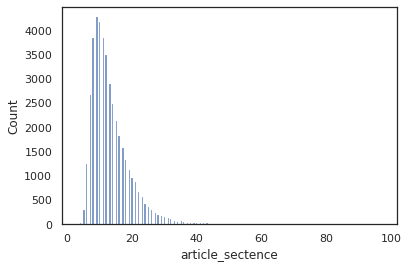

In [14]:
sns.histplot(data['article_sectence'])

In [21]:
ext_sent = []
for sent in data['extractive']:
  for s in sent:
    ext_sent.append(s)

print(ext_sent) # 추출문 인덱스 모음

[0, 1, 2, 0, 1, 3, 6, 7, 10, 1, 6, 4, 2, 3, 10, 0, 3, 1, 1, 2, 4, 0, 3, 5, 2, 3, 7, 3, 5, 12, 1, 4, 6, 2, 3, 6, 1, 2, 0, 0, 1, 2, 0, 1, 12, 0, 2, 3, 0, 1, 2, 1, 3, 4, 2, 3, 4, 2, 10, 11, 1, 2, 5, 2, 3, 6, 0, 1, 2, 0, 1, 4, 0, 1, 6, 3, 6, 7, 0, 1, 2, 14, 7, 4, 4, 5, 8, 0, 2, 5, 1, 2, 3, 0, 1, 2, 0, 1, 9, 0, 1, 12, 0, 3, 12, 0, 1, 7, 2, 3, 1, 1, 2, 15, 1, 3, 4, 1, 5, 7, 0, 10, 12, 0, 1, 2, 0, 2, 1, 3, 10, 11, 4, 2, 3, 1, 4, 6, 0, 15, 16, 0, 3, 9, 5, 22, 2, 3, 2, 5, 0, 2, 1, 0, 1, 4, 0, 1, 2, 2, 7, 10, 1, 2, 7, 0, 2, 6, 2, 4, 5, 0, 2, 7, 1, 4, 2, 3, 5, 9, 0, 1, 2, 0, 4, 6, 0, 1, 2, 2, 3, 4, 1, 6, 13, 0, 2, 3, 0, 1, 2, 2, 3, 5, 0, 2, 3, 0, 1, 3, 4, 5, 7, 2, 6, 11, 1, 2, 3, 2, 3, 4, 3, 4, 18, 1, 6, 4, 0, 1, 5, 1, 2, 4, 3, 4, 11, 4, 7, 11, 2, 3, 5, 3, 17, 28, 5, 4, 2, 0, 1, 8, 0, 21, 6, 3, 5, 6, 0, 1, 2, 1, 2, 3, 0, 1, 8, 1, 10, 0, 1, 2, 0, 1, 2, 0, 2, 3, 0, 1, 3, 5, 6, 16, 2, 4, 3, 0, 1, 10, 0, 4, 8, 0, 3, 4, 2, 21, 3, 7, 5, 1, 4, 3, 0, 10, 3, 0, 1, 2, 0, 2, 1, 0, 4, 2, 2, 12, 4, 3, 4, 5, 0

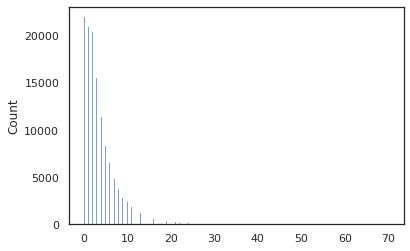

In [22]:
sns.histplot(ext_sent)

In [ ]:
!pip install -U pandas-profiling

     |████████████████████████████████| 245kB 16.9MB/s 
     |████████████████████████████████| 81kB 12.1MB/s 
     |████████████████████████████████| 1.1MB 59.6MB/s 
     |████████████████████████████████| 81kB 9.8MB/s 
     |████████████████████████████████| 61kB 8.6MB/s 
     |████████████████████████████████| 3.2MB 51.3MB/s 
     |████████████████████████████████| 296kB 56.8MB/s 
  Created wheel for phik: filename=phik-0.11.2-cp37-none-any.whl size=1107413 sha256=a94caeb697d918f4c3c14c477d2e399750a7fbe254a66be6018e475ff9eebfa1
  Stored in directory: /root/.cache/pip/wheels/c0/a3/b0/f27b1cfe32ea131a3715169132ff6d85653789e80e966c3bf6
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp37-none-any.whl size=27085 sha256=b357719ea001080415814508b2e955b5fda03a2cc693aca754523ad638e41540
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
Successfully built phik htmlmin
ERROR: transformers 3.5.1 has requirement sentencepiece==0.1.91

In [ ]:
import pandas_profiling as pp
pp.ProfileReport(data)

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 3. 데이터 전처리

In [29]:
for i in range(len(data.article_original)):
  sentence= ''
  for j in range(len(data.article_original[i])):
    sentence += ' ' + data.article_original[i][j]
  data.article_original[i] = sentence

In [30]:
data['prp_article'] = data['article_original'].str.replace('．','.').str.replace('\n',' ')

In [31]:
print(data['prp_article'][6483])
print(data['prp_article'][0])
print(data['prp_article'][19815])

 업무협약 체결식에는 이혁재 안동대 산학협력단장과 LINC+사업단 교수 및 중국 선진지역 문화산업 탐방 연수단 학생， 현지 기관 및 기업체 관계자 등 30여 명이 참석했다. 이번 협약에 따라 안동대 공자학원과 해당 중국 현지 기업(기관)은 학생 취업·창업 역량 강화를 위한 인턴십 및 현장실습 기초역량 강화， 대학 및 기관(기업) 간 공동추진 프로그램 운영， 안동지역 기업의 중국 진출을 위한 교두보 확보 및 네트워크 구축， 중국 현지 취·창업 정보 지원 및 애로사항에 관한 자문 등을 위해 상호협력키로 했다. 또 안동대 공자학원은 LINC+사업팀과 연계해 지난달 21일부터 24일까지 3박 4일간 “중국 문화산업 선진지역 탐방 연수단”을 인솔해 상하이의 문화산업기반 기관 및 기업을 탐방하고 중국 취·창업관련 특강과 세미나를 개최했다. 공자학원 송환아 원장은 “글로벌 취·창업시대를 맞이해 앞으로도 안동대학교 학생들의 중국 취·창업 역량 강화와 지역 기업들의 중국 진출 지원을 위해 보다 구체적인 노력을 기울일 것”이라고 밝혔다. 안동대 공자학원, 중국 상하이 현지 기업을 방문해 취·창업 지원을 위한 상호업무교류 협약 체결했다.
 당진시 문화관광과를 대상으로 하는 행정사무감사에서 당진시립합창단 관계자가 보낸 것으로 추정되는 문자와 관련해 당진시의회가 행정사무조사특별위원회를 구성해 조사하겠다고 밝혔다. 당진시의회 행정사무감사 3일차였던 지난 6일 문화관광과를 대상으로 하는 행감에서 최창용 의원은 “(당진시립합창단 정기연주회를 앞두고) 문자메세지를 제보받았다”며 “(음향팀에 보낸 것으로 추정되는) 해당 문자에는 ‘합창단이 소리를 작게 낼 것이니 알고 있으라’는 내용이었다”고 말했다. 이어 “공연에서 소리를 작게 낸다는 것은 합창단으로서 그 임무를 하지 않겠다는 것”이며 “공연 자체를 무력화해 당진시를 망신 주려는 행위”라며 해당 문자를 보낸 단원 등 연루된 사람들을 찾아 사실관계를 확인하고 징계 등 책임을 물어야 한다고 지적했다. 문제의 문자메세지를 전달받은 문화관광과는 감

In [32]:
# train, test data 분할
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=2)

In [33]:
train.shape, test.shape

((34242, 7), (8561, 7))

In [34]:
target = 'extractive'
X_train = train['prp_article']
y_train = train[target]
X_test = test['prp_article']
y_test = test[target]

## 4. gensim library를 활용한 추출요약

In [35]:
# gensim summarizer - TextRank 기반(키워드 추출 기능과 핵심 문장 추출 기능)
from gensim.summarization.summarizer import summarize

#[6483] ' .' <-마침표가 다른 특수문자라서 문장으로 인식하지 못함 =>전처리필요 // [15736] 시(마침표 없음) => 문장으로 인식하지 못함
# for i in range(len(data['prp_article'])):
#   print(i,summarize(data['prp_article'][i],word_count=20))

In [36]:
gdata = data.drop(index=15736)

In [37]:
gdata

,media,id,article_original,abstractive,extractive,article_sectence,prp_article
0,당진시대,327827480,당진시 문화관광과를 대상으로 하는 행정사무감사에서 당진시립합창단 관계자가 보낸 것...,지난 6일 당진시의회 행정사무감사에서 '합창단이 소리를 작게 낼 것이니 알고 있으라...,"[0, 1, 2]",9,당진시 문화관광과를 대상으로 하는 행정사무감사에서 당진시립합창단 관계자가 보낸 것...
1,국제신문,339840364,미국 메이저리그(MLB)에서 활동하는 한국 선수들의 시즌 초반 희비가 엇갈리고 있...,LA 에인절스의 최지만이 맹활약을 하여 시즌 타율 0.250에서 0.313으로 올리...,"[0, 1, 3]",21,미국 메이저리그(MLB)에서 활동하는 한국 선수들의 시즌 초반 희비가 엇갈리고 있...
2,기호일보,371071597,인천 부영공원 운영 생활야구협회 80여 동호회 팀에 260만 원씩 받아 국유지로 ...,16일 부평구와 협회 등에 따르면 부영공원 안에 있는 야구장을 구생활체육야구협회가 ...,"[6, 7, 10]",19,인천 부영공원 운영 생활야구협회 80여 동호회 팀에 260만 원씩 받아 국유지로 ...
3,대구일보,354806783,대구·경북첨단의료산업진흥재단 의약생산센터는 항암주사제 무균충전 시설을 갖추고 있다...,대구·경북첨단의료산업진흥재단 의약생산센터는 약사법 시행규칙에서 정한 바에 따라 전용...,"[1, 6, 4]",10,대구·경북첨단의료산업진흥재단 의약생산센터는 항암주사제 무균충전 시설을 갖추고 있다...
4,대구신문,347022773,국내 유통되는 탄산음료 중 식품의약품안전처에 품질인증을 받은 제품이 하나도 없는 ...,식품의약품안전처는 29일 어린이가 즐겨마시는 음료를 대상으로 영양성분을 조사한 결과...,"[2, 3, 10]",13,국내 유통되는 탄산음료 중 식품의약품안전처에 품질인증을 받은 제품이 하나도 없는 ...
...,...,...,...,...,...,...,...
42798,대구신문,334074661,칠곡북삼초등학교(교장 서금자)에서는 지난달 7일부터 18일까지 3-5학년 학생 중...,지난달 7일부터 18일까지 칠곡북삼초등학교는 학생들에게 실제 영어 사용에 대한 자신...,"[0, 1, 2]",9,칠곡북삼초등학교(교장 서금자)에서는 지난달 7일부터 18일까지 3-5학년 학생 중...
42799,대구일보,362902654,"김상훈 의원 최근 5년간, LH공공임대 임차인이 사망했으나 상속되거나 반환되지 못...",김상훈 자유한국당 의원은 최근 5년간 임차인의 사망으로 반환되지 못한 3천479가구...,"[1, 2, 4]",11,"김상훈 의원 최근 5년간, LH공공임대 임차인이 사망했으나 상속되거나 반환되지 못..."
42800,기호일보,355310553,▲ 5일 오전 파주 임진각에서 열린 ‘DMZ 155마일 걷기’ 출정식에서 걷기대원...,경기도는 DMZ의 의미와 평화에 관한 국민들의 인식을 새롭게 하고자 'DMZ 1...,"[2, 3, 6]",11,▲ 5일 오전 파주 임진각에서 열린 ‘DMZ 155마일 걷기’ 출정식에서 걷기대원...
42801,당진시대,288844233,"당진지역 휘발유 평균 가격은 1534원, 경유 평균가격은 1343원으로 조사됐다....",지난 14일 기준 당진지역 휘발유 중 가장 저렴한 곳의 가격은 AJ토탈(주)당진주유...,"[4, 6, 0]",13,"당진지역 휘발유 평균 가격은 1534원, 경유 평균가격은 1343원으로 조사됐다...."


In [41]:
# gensim summarizer - TextRank 기반(키워드 추출 기능과 핵심 문장 추출 기능)
from gensim.summarization.summarizer import summarize

gdata['smr_atcl'] = gdata['prp_article'].apply(summarize,word_count=20)

In [42]:
gdata['article_original'][16210]

' 서산시는 13일 본죽으로 유명한 국내 대표 한식 프랜차이즈 기업 본아이에프와 서울 영등포구에 위치한 본아이에프 사옥에서 업무 협약(MOU)을 체결했다. 사진=서산시 제공 [서산]서산시는 13일 본죽으로 유명한 국내 대표 한식 프랜차이즈 기업 본아이에프와 서울 영등포구에 위치한 본아이에프 사옥에서 업무 협약(MOU)을 체결했다고 밝혔다. 맹정호 시장과 본아이에프 김명환 대표이사는 이번 협약에 따라 농특산물의 납품과 이를 활용한 신 메뉴 개발 등 동반 성장을 위해 상호 협력키로 했다. 시는 \'서산달래\', \'냉이\' 등 다양한 지역 농특산물이 안정적이고, 원활하게 공급할 수 있도록 행정 지도를 적극 수행 할 계획이다. 이 회사는 MOU 체결에 앞서 \'본죽 및 본죽&비빔밥 카페\'를 통해 서산달래를 활용한 \'새꼬막 달래 비빔밥\', \'달래 차돌 강된장 비빔밥\'을 출시하고, 가정간편식 브랜드 \'아침엔본죽\'을 통해 서산냉이를 담은 즉석 죽 \'봄냉이바지락죽\'을 선보인 바 있다. 본아이에프는 2002년 9월 본죽 1호점을 시작으로 전국에 약 1800개 매장을 보유한 연 매출 1700억 원의 국내 대표 한식 프랜차이즈 기업이다. 맹정호 시장은 "이번 MOU 체결은 농특산물의 추가 납품 등 판로확보를 통한 농가소득 안정화에 기여할 수 있는 좋은 기회"라며 "앞으로도 지역 농특산물의 안정적인 판로 구축에 지속적인 노력을 기울여 나가겠다"고 말했다.'

In [43]:
gdata['smr_atcl'][16210]

'서산시는 13일 본죽으로 유명한 국내 대표 한식 프랜차이즈 기업 본아이에프와 서울 영등포구에 위치한 본아이에프 사옥에서 업무 협약(MOU)을 체결했다.'

In [ ]:
gdata['id'][gdata['smr_atcl']==gdata['smr_atcl'].max()]

19815    349940500
Name: id, dtype: int64

In [ ]:
data[data['id']==349940500]

,media,id,article_original,abstractive,extractive,article_sectence,prp_article
19815,대구일보,349940500,＃얼마 전 대구 동구 효목1동 한 골목에서 고양이 한 마리가 죽은 채 발견됐다. ...,대구지방경찰청에 따르면 대구지역 여러곳에서 고양이 학대로 추정되는 상황이 자주 발생...,"[10, 11, 19]",24,＃얼마 전 대구 동구 효목1동 한 골목에서 고양이 한 마리가 죽은 채 발견됐다. ...


In [ ]:
import json

with open('train.jsonl') as f:
  jdata = json.load(f)

JSONDecodeError: ignored

## koBertSum 적용

In [ ]:
!git clone https://github.com/uoneway/KoBertSum.git

Cloning into 'KoBertSum'...
remote: Enumerating objects: 733, done.
remote: Counting objects: 100% (733/733), done.
remote: Compressing objects: 100% (324/324), done.
remote: Total 733 (delta 480), reused 648 (delta 396), pack-reused 0
Receiving objects: 100% (733/733), 15.22 MiB | 14.84 MiB/s, done.
Resolving deltas: 100% (480/480), done.


In [ ]:
%cd ./KoBertSum

In [ ]:
!python main.py -task install

/content/KoBertSum
     |████████████████████████████████| 1.6MB 4.1MB/s 
     |████████████████████████████████| 20.3MB 51.0MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 1.3MB 32.4MB/s 
     |████████████████████████████████| 194kB 35.6MB/s 
     |████████████████████████████████| 676.9MB 28kB/s 
     |████████████████████████████████| 890kB 33.1MB/s 
     |████████████████████████████████| 1.1MB 31.9MB/s 
     |████████████████████████████████| 2.9MB 35.5MB/s 
  Created wheel for multiprocess: filename=multiprocess-0.70.9-cp37-none-any.whl size=108029 sha256=31402b55637337632bd8c4e4d5c01f0d5e0f0632366b5aaa8866a1b84aa139b9
  Stored in directory: /root/.cache/pip/wheels/96/20/ac/9f1d164f7d81787cd6f4401b1d05212807d021fbbbcc301b82
  Created wheel for pyrouge: filename=pyrouge-0.1.3-cp37-none-any.whl size=191613 sha256=66af9a30344b3398d79411a4977f31c41b2c92ba945107076732aaa303c68aed
  Stored in directory: /root/.cache/pip/wheels/75/d3/

In [ ]:
# 데이터 Preprocessing
# 데이터를 ext/data/raw 에 넣어준 후 다음을 실행하여 BERT 입력을 위한 형태로 변환합니다.
# n_cpus: 연산에 이용할 CPU 수
!python main.py -task make_data -target_summary_sent ext -n_cpus 2

/content/KoBertSum
train_df(40663) is exported
valid_df(2140) is exported
test_df(9987) is exported
  0% 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
  7% 3/41 [00:17<03:47,  5.99s/it]/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:273: UserWarning: "b'/'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 10% 4/41 [00:23<03:41,  5.99s/it]/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://www.ivips.co.kr:7002/event/evthoteventprttpl.asp?eventkey=86" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Be

In [ ]:
# Fine-tuning
# KoBERT 모델을 기반으로 fine-tuning을 진행하고, 1,000 step마다 Fine-tuned model 파일(.pt)을 저장합니다.
!python main.py -task train -target_summary_sent abs -visible_gpus 0

/content/KoBertSum
mkdir: cannot create directory ‘/content/KoBertSum/ext/models/1209_1236’: File exists
python train.py -task ext -mode train -bert_data_path /content/KoBertSum/ext/data/bert_data/train_abs -save_checkpoint_steps 1000 -visible_gpus 0 -report_every 50 -ext_dropout 0.1 -max_pos 512 -lr 2e-3 -warmup_steps 10000 -batch_size 3000 -accum_count 2 -train_steps 50000  -use_interval true -model_path /content/KoBertSum/ext/models/1209_1236 -log_file /content/KoBertSum/ext/logs/train_1209_1236.log
2021-03-15 12:02:00.296386: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
[2021-03-15 12:02:02,591 INFO] Device ID 0
[2021-03-15 12:02:02,591 INFO] Device cuda
[2021-03-15 12:02:08,115 INFO] ExtSummarizer(
  (bert): Bert(
    (model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(8002, 768, padding_idx=1)
        (position_embeddings): Embedding(512, 768)
        (token_type_embe

In [ ]:
# Validation
# Fine-tuned model마다 validation data set을 통해 inference를 시행하고, loss 값을 확인합니다.
# model_path: model 파일(.pt)이 저장된 폴더 경로
!python main.py -task valid -model_path 1209_1236

In [ ]:
# Inference & make submission file
# Validation을 통해 확인한 가장 성능이 우수한 model파일을 통해 실제로 텍스트 요약 과업을 수행합니다.
# test_from: model 파일(.pt) 경로
# visible_gpus: 연산에 이용할 gpu index를 입력. 예) (GPU 3개를 이용할 경우): 0,1,2
# 결과는 ext/data/results/ 폴더에 result_1209_1236_step_7000.candidate 및 submission_날짜_시간.csv 형태로 저장

!python main.py -task test -test_from 1209_1236/model_step_7000.pt -visible_gpus 0